In [43]:
import json
from generate_dataset import Sample

# Load dataset
with open("dataset.json", "r") as f:
    dataset = [Sample.model_validate(sample) for sample in json.load(f)]

MODEL_NAME_LOOKUP = {
    "GPT-4o": "gpt4o",
    "GPT-4o mini": "gpt4-mini",
    "Claude Sonnet": "claude-3.5-sonnet",
    "Gemini 1.5 Flash": "gemini-1.5-flash",
    "Gemini 1.5 Pro": "gemini-1.5-pro"
}
TYPE_LOOKUP = {
    "text": "text",
    "image": "image",
    "image+text": "image-text"
}

dataset_predictions = []
for name, key in MODEL_NAME_LOOKUP.items():
    for type, ext in TYPE_LOOKUP.items():
        with open(f"predictions/{key}_{ext}.json", "r") as f:
            dataset_predictions.append([name, type, json.load(f)])

### Cleaning predicitons

In [44]:
model_fails = {}
for dataset_pred in dataset_predictions:
    for key in dataset_pred[2]: 
        dataset_pred[2][key] = dataset_pred[2][key].replace(",","").lower()
        if dataset_pred[2][key] not in ["shift", "static", "rotate", "flip"]: 
            dataset_pred[2][key] = "rotate"
            model_fails[dataset_pred[0]] = model_fails.get(dataset_pred[0], 0) + 1

print(model_fails)

{}


### Accuracies

In [45]:
from sklearn.metrics import f1_score


results = []

for i, predictions in enumerate(dataset_predictions): 
    data = [(predictions[2][sample.uuid], sample.transformation.type.value) for sample in dataset]
    preds, labels = zip(*data)
    correct = 0
    for j in range(len(preds)):
        if preds[j] == labels[j]:
            correct+=1

    accuracy = correct / len(preds)

    results.append((predictions[0], predictions[1], accuracy))

    print(f'{predictions[0]} ({predictions[1]})')
    print("Accuracy:", round(correct / len(preds),2))
    print("F1:", round(f1_score(labels, preds, average = "macro"),2))
    print()


GPT-4o (text)
Accuracy: 0.49
F1: 0.44

GPT-4o (image)
Accuracy: 0.4
F1: 0.36

GPT-4o (image+text)
Accuracy: 0.55
F1: 0.5

GPT-4o mini (text)
Accuracy: 0.39
F1: 0.35

GPT-4o mini (image)
Accuracy: 0.26
F1: 0.12

GPT-4o mini (image+text)
Accuracy: 0.3
F1: 0.21

Claude Sonnet (text)
Accuracy: 0.69
F1: 0.69

Claude Sonnet (image)
Accuracy: 0.69
F1: 0.68

Claude Sonnet (image+text)
Accuracy: 0.76
F1: 0.76

Gemini 1.5 Flash (text)
Accuracy: 0.42
F1: 0.32

Gemini 1.5 Flash (image)
Accuracy: 0.42
F1: 0.39

Gemini 1.5 Flash (image+text)
Accuracy: 0.49
F1: 0.45

Gemini 1.5 Pro (text)
Accuracy: 0.59
F1: 0.56

Gemini 1.5 Pro (image)
Accuracy: 0.55
F1: 0.53

Gemini 1.5 Pro (image+text)
Accuracy: 0.67
F1: 0.65



In [46]:
# Get best input type for each model
best_input_types = {}
for result in results:
    if result[0] not in best_input_types:
        best_input_types[result[0]] = (result[1], result[2])
    elif result[2] > best_input_types[result[0]][1]:
        best_input_types[result[0]] = (result[1], result[2])

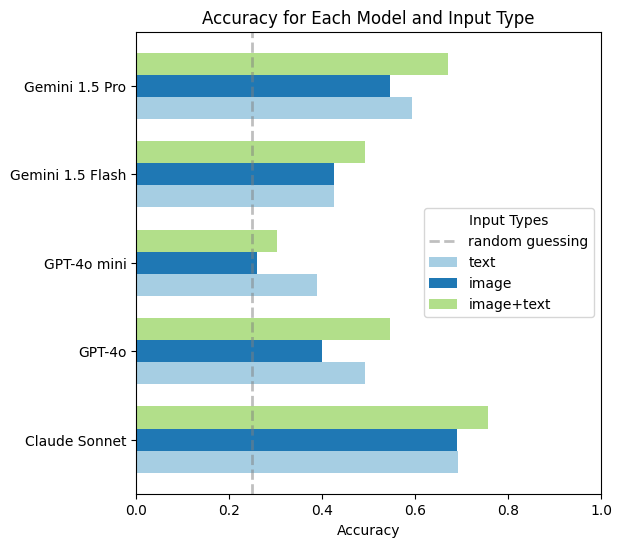

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Assume MODEL_NAME_LOOKUP, TYPE_LOOKUP, and results are defined with data

models = list(MODEL_NAME_LOOKUP.keys())
input_types = list(TYPE_LOOKUP.keys())

models.sort()

accuracy_dict = {model: {input_type: 0 for input_type in input_types} for model in models}

# Fill the dictionary with actual accuracy data
for model, input_type, accuracy in results:
    accuracy_dict[model][input_type] = accuracy


colors = plt.cm.Paired.colors

# Plotting setup
fig, ax = plt.subplots(figsize=(6, 6))
bar_width = 0.2  # Width of each bar
space_between_models = 0.2  # Space between groups of bars for different models
indices = []

# Calculate positions for each group of bars
index_offset = 0
for model in models:
    indices.append(index_offset)
    index_offset += len(input_types) * bar_width + space_between_models

# Generate bars for each input type within each model group
for i, input_type in enumerate(input_types):
    bar_positions = [idx + i * bar_width for idx in indices]
    accuracies = [accuracy_dict[model][input_type] for model in models]
    ax.barh(bar_positions, accuracies, bar_width, color=colors[i % len(colors)], label=input_type)

# Set labels and title
ax.set_yticks([idx + (len(input_types) - 1) * bar_width / 2 for idx in indices])
ax.set_yticklabels(models)
ax.set_xlabel("Accuracy")
ax.set_title("Accuracy for Each Model and Input Type")
ax.set_xlim(0, 1)  # Assuming accuracy between 0 and 1

# Add vertical dotted grey line at 0.25 to represent random guessing
ax.axvline(0.25, color='grey', linestyle='--', linewidth=2, alpha=0.5, label='random guessing')

# Add legend for input types
ax.legend(title="Input Types")

plt.show()


### Measuring the effect of grid-size

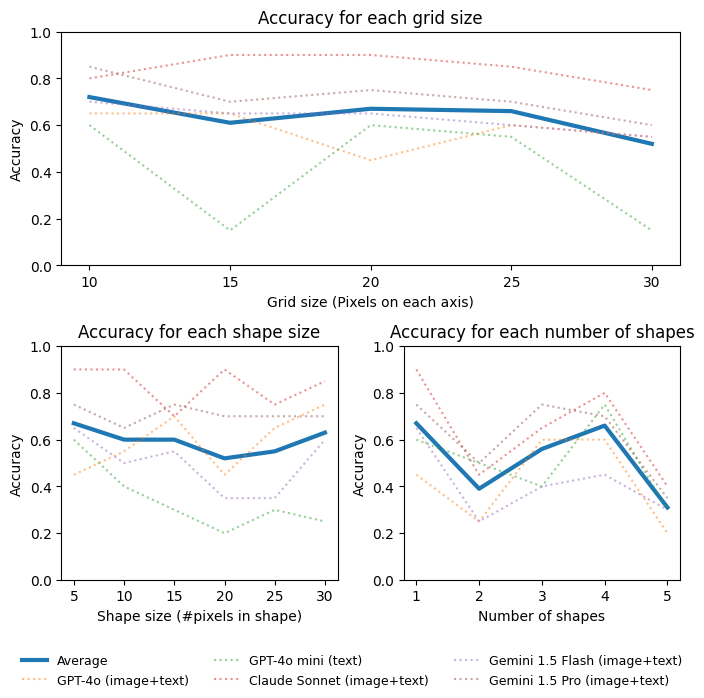

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

DISREGARD_SHIFTS = False
grid_sizes = list(range(10, 31, 5))  # Plot accuracy for each grid size
shape_sizes = list(range(5, 31, 5))
x_axis = list(range(1, 6))  # For number of shapes

# Filter dataset_predictions to only keep best models
best_models_predictions = [predictions for predictions in dataset_predictions if (predictions[0] in best_input_types and predictions[1] == best_input_types[predictions[0]][0])]

fig = plt.figure(figsize=(7, 7))  # Set the figure size
gs = GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1], figure=fig)  # Two rows, with the first row being taller

# Large plot on top: Accuracy for each grid size
ax1 = fig.add_subplot(gs[0, :])  # This takes the entire first row
model_accuracies = []
for predictions in best_models_predictions:
    accuracies = []
    for grid_size in grid_sizes:
        grid_size_samples = [
            sample for sample in dataset if sample.configuration.grid_size == grid_size
            and sample.configuration.shape_size == 5 and sample.configuration.number_of_shapes == 1
        ]
        if DISREGARD_SHIFTS: 
            grid_size_samples = [sample for sample in grid_size_samples if sample.transformation.type.value != "shift"]

        
        grid_size_samples_predictions = [predictions[2][sample.uuid] for sample in grid_size_samples]
        accuracy = sum([pred == sample.transformation.type.value for pred, sample in zip(grid_size_samples_predictions, grid_size_samples)]) / len(grid_size_samples)
        accuracies.append(accuracy)
    model_accuracies.append(accuracies)

avg_accuracies = np.mean(model_accuracies, axis=0)

ax1.plot(grid_sizes, avg_accuracies, color=f'C0', linewidth=3, label="Average")
for i, accuracies in enumerate(model_accuracies):
    ax1.plot(grid_sizes, accuracies, color=f'C{i+1}', linestyle=':', alpha=0.5, label=f'{best_models_predictions[i][0]} ({best_models_predictions[i][1]})')

ax1.set_title("Accuracy for each grid size", fontsize=12)
ax1.set_xlabel("Grid size (Pixels on each axis)", fontsize=10)
ax1.set_ylabel("Accuracy", fontsize=10)
ax1.set_ylim(0, 1)
ax1.set_xticks(grid_sizes)

# Smaller plot 1 on the bottom left: Accuracy for each shape size
ax2 = fig.add_subplot(gs[1, 0])
model_accuracies = []
for predictions in best_models_predictions:
    accuracies = []
    for shape_size in shape_sizes:
        shape_size_samples = [
            sample for sample in dataset if sample.configuration.shape_size == shape_size
            and sample.configuration.grid_size == 20 and sample.configuration.number_of_shapes == 1
        ]
        shape_size_samples_predictions = [predictions[2][sample.uuid] for sample in shape_size_samples]
        accuracy = sum([pred == sample.transformation.type.value for pred, sample in zip(shape_size_samples_predictions, shape_size_samples)]) / len(shape_size_samples)
        accuracies.append(accuracy)
    model_accuracies.append(accuracies)

avg_accuracies = np.mean(model_accuracies, axis=0)

ax2.plot(shape_sizes, avg_accuracies, color=f'C0', linewidth=3, label="Average")
for i, accuracies in enumerate(model_accuracies):
    ax2.plot(shape_sizes, accuracies, color=f'C{i+1}', linestyle=':', alpha=0.5, label=f'{best_models_predictions[i][0]} ({best_models_predictions[i][1]})')

ax2.set_title("Accuracy for each shape size", fontsize=12)
ax2.set_xlabel("Shape size (#pixels in shape)", fontsize=10)
ax2.set_ylabel("Accuracy", fontsize=10)
ax2.set_ylim(0, 1)
ax2.set_xticks(shape_sizes)

# Smaller plot 2 on the bottom right: Accuracy for each number of shapes
ax3 = fig.add_subplot(gs[1, 1])
model_accuracies = []
for predictions in best_models_predictions:
    accuracies = []
    for number_of_shapes in x_axis:
        number_of_shapes_samples = [
            sample for sample in dataset if sample.configuration.number_of_shapes == number_of_shapes
            and sample.configuration.shape_size == 5 and sample.configuration.grid_size == 20
        ]
        number_of_shapes_samples_predictions = [predictions[2][sample.uuid] for sample in number_of_shapes_samples]
        accuracy = sum([pred == sample.transformation.type.value for pred, sample in zip(number_of_shapes_samples_predictions, number_of_shapes_samples)]) / len(number_of_shapes_samples)
        accuracies.append(accuracy)
    model_accuracies.append(accuracies)

avg_accuracies = np.mean(model_accuracies, axis=0)

ax3.plot(x_axis, avg_accuracies, color=f'C0', linewidth=3, label="Average")
for i, accuracies in enumerate(model_accuracies):
    ax3.plot(x_axis, accuracies, color=f'C{i+1}', linestyle=':', alpha=0.5, label=f'{best_models_predictions[i][0]} ({best_models_predictions[i][1]})')

ax3.set_title("Accuracy for each number of shapes", fontsize=12)
ax3.set_xlabel("Number of shapes", fontsize=10)
ax3.set_ylabel("Accuracy", fontsize=10)
ax3.set_ylim(0, 1)
ax3.set_xticks(x_axis)

# Create a single legend for all subplots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, frameon=False, fontsize=9)

# Adjust layout
fig.tight_layout(rect=[0, 0.08, 1, 1])  # Adjust layout to fit the legend at the bottom
plt.show()


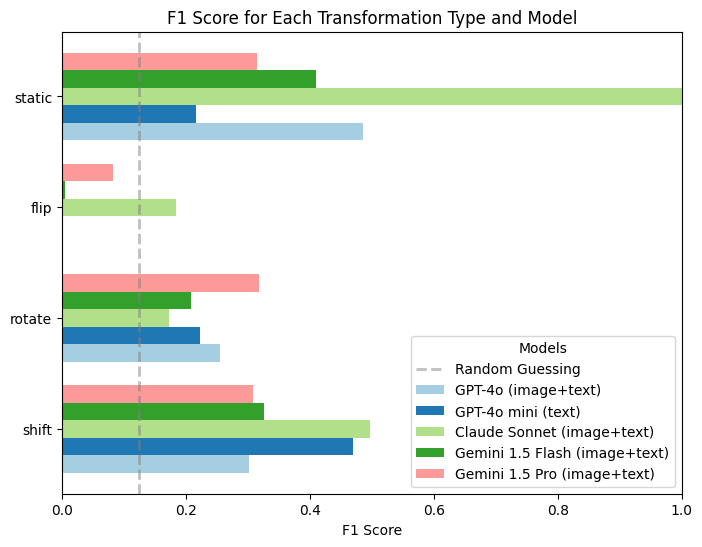

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

# Assuming we have dataset_predictions, dataset, and best_input_types

# Filter to best input type for each model
best_models_predictions = [
    predictions for predictions in dataset_predictions
    if predictions[0] in best_input_types and predictions[1] == best_input_types[predictions[0]][0]
]

# Define the transformations
transformations = ["shift", "rotate", "flip", "static"]
models = [pred[0] for pred in best_models_predictions]  # List of best models
model_f1_dict = {model: {transformation: 0 for transformation in transformations} for model in models}

# Calculate F1 scores for each model and transformation type
for predictions in best_models_predictions:
    model_name = predictions[0]
    for transformation in transformations:
        transformation_samples = [
            sample for sample in dataset if sample.transformation.type.value == transformation
        ]
        transformation_samples_predictions = [predictions[2][sample.uuid] for sample in transformation_samples]
        
        if transformation_samples:
            y_true = [sample.transformation.type.value for sample in transformation_samples]
            f1 = f1_score(y_true, transformation_samples_predictions, average="macro")
            model_f1_dict[model_name][transformation] = f1

# Plotting setup
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.15  # Width of each bar
space_between_models = 0.2  # Space between groups of bars for different models
indices = []

# Calculate positions for each group of bars (one per transformation type)
index_offset = 0
for i, transformation in enumerate(transformations):
    indices.append(index_offset)
    index_offset += len(models) * bar_width + space_between_models

# Generate bars for each model within each transformation group
colors = plt.cm.Paired.colors
for i, model in enumerate(models):
    bar_positions = [idx + i * bar_width for idx in indices]
    f1_scores = [model_f1_dict[model][transformation] for transformation in transformations]
    ax.barh(bar_positions, f1_scores, bar_width, color=colors[i % len(colors)], label=f'{model} ({best_input_types[model][0]})')

# Set labels and title
ax.set_yticks([idx + (len(models) - 1) * bar_width / 2 for idx in indices])
ax.set_yticklabels(transformations)
ax.set_xlabel("F1 Score")
ax.set_title("F1 Score for Each Transformation Type and Model")
ax.set_xlim(0, 1)  # Assuming F1 score between 0 and 1

# Add a vertical dotted line to represent random guessing if applicable
ax.axvline(0.125, color='grey', linestyle='--', linewidth=2, alpha=0.5, label='Random Guessing')

# Add legend for models
ax.legend(title="Models")

plt.show()


In [50]:
import scipy.ndimage

def find_continuous_shape(grid: np.ndarray) -> list[tuple[int, int]]:
    mask = grid == 1
    labels, _ = scipy.ndimage.label(mask)
    return [(int(x), int(y)) for y, x in zip(*labels.nonzero())]

def find_center_shape(grid: np.ndarray) -> np.ndarray:
    coordinates = find_continuous_shape(grid)
    min_x = min(x for x, y in coordinates)
    max_x = max(x for x, y in coordinates)
    min_y = min(y for x, y in coordinates)
    max_y = max(y for x, y in coordinates)

    # Step 2: Calculate the size of the subgrid
    width = max_x - min_x + 1
    height = max_y - min_y + 1

    # Step 3: Initialize the grid
    grid = np.zeros((height, width), dtype=int)

    # Step 4: Shift coordinates and populate the grid
    for x, y in coordinates:
        shifted_x = x - min_x
        shifted_y = y - min_y
        grid[shifted_y, shifted_x] = 1  # Mark shape cells as 1

    return grid

find_center_shape(np.array(dataset[9].grid_before))

array([[0, 0, 1],
       [0, 0, 1],
       [1, 0, 1],
       [1, 1, 1],
       [1, 1, 1]])

In [51]:
from scipy.spatial.distance import hamming

def hamming_distance(arr1, arr2):
    return hamming(arr1.flatten(), arr2.flatten()) * arr1.size

def find_min_hamming_distance(shape: np.ndarray) -> tuple[int, int]:
    return min([
        hamming_distance(shape, np.rot90(shape, k=k)) for k in range(1, 4)
    ] + [
        hamming_distance(shape, np.fliplr(shape))
    ] + [
        hamming_distance(np.flipud(shape), np.rot90(shape, k=k)) for k in range(3)
    ])

/var/folders/s3/51rzg94s5318dvd1cr9t6cq40000gn/T/ipykernel_61324/2066392487.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_accuracy_per_bin[model_name] = df.groupby('min_hd_bin')['accuracy'].mean()
/var/folders/s3/51rzg94s5318dvd1cr9t6cq40000gn/T/ipykernel_61324/2066392487.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_accuracy_per_bin[model_name] = df.groupby('min_hd_bin')['accuracy'].mean()
/var/folders/s3/51rzg94s5318dvd1cr9t6cq40000gn/T/ipykernel_61324/2066392487.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pan

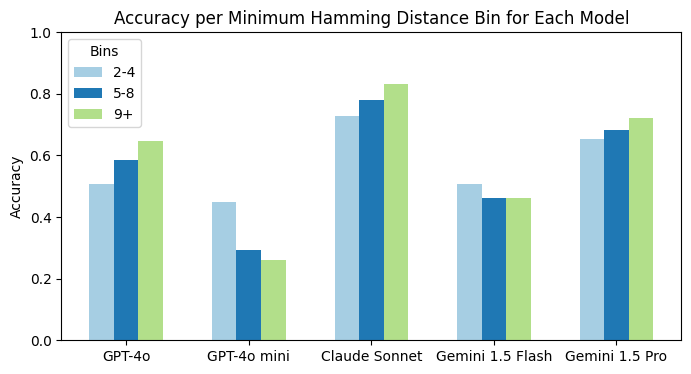

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define bins and labels
bins = [1, 4, 8, 40]
labels = ['2-4', '5-8', '9+']

# Initialize a dictionary to store accuracy per bin for each model
model_accuracy_per_bin = {}

# Calculate accuracy per bin for each model in best_models_predictions
for predictions in best_models_predictions:
    model_name = predictions[0]
    model_accuracy_data = []

    # Collect data for each sample in the dataset
    for sample in dataset:
        shape = find_center_shape(np.array(sample.grid_before))
        shape_size = len(find_continuous_shape(shape))
        min_hd = int(find_min_hamming_distance(shape))
        relative_hd = min_hd / shape_size
        prediction = predictions[2][sample.uuid]
        accuracy = prediction == sample.transformation.type.value

        # Append data
        model_accuracy_data.append((min_hd, relative_hd, accuracy))

    # Create a DataFrame
    df = pd.DataFrame(model_accuracy_data, columns=['min_hd', 'relative_hd', 'accuracy'])
    
    # Bin the 'min_hd' values
    df['min_hd_bin'] = pd.cut(df['min_hd'], bins=bins, labels=labels, right=False)
    
    # Calculate accuracy per bin and store it
    model_accuracy_per_bin[model_name] = df.groupby('min_hd_bin')['accuracy'].mean()

# Plotting setup
fig, ax = plt.subplots(figsize=(8, 4))
bar_width = 0.2  # Width of each bar
space_between_bins = 0.4  # Space between groups of bars for each bin
num_bins = len(labels)

# Calculate positions for each model group
indices = np.arange(len(model_accuracy_per_bin)) * (num_bins * bar_width + space_between_bins)

# Generate horizontal bars for each bin within each model group
colors = plt.cm.Paired.colors
for j, bin_label in enumerate(labels):
    bin_accuracies = [model_accuracy_per_bin[model][bin_label] for model in model_accuracy_per_bin.keys()]
    # Calculate the positions for the bars of each bin within the model groups
    bar_positions = indices + j * bar_width
    ax.bar(bar_positions, bin_accuracies, bar_width, color=colors[j % len(colors)], label=bin_label)

# Set labels and title
ax.set_xticks(indices + (num_bins - 1) * bar_width / 2)
ax.set_xticklabels(model_accuracy_per_bin.keys())
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy per Minimum Hamming Distance Bin for Each Model")
ax.set_ylim(0, 1)  # Assuming accuracy values between 0 and 1

# Add legend for bins
ax.legend(title="Bins")

plt.show()